In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as pp
import pylab as pl
import folium
from IPython.display import HTML
import seaborn as sns
from scipy import stats
from folium.plugins import MarkerCluster

In [2]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [7]:
result = pd.read_csv('/Users/ryan/Desktop/combined_baseline_may19.csv', header=0, dtype= 'unicode')

result['hh_size_hhinfo'] = pd.to_numeric(result['hh_size_hhinfo'], errors='coerce')
result['refusal'] = pd.to_numeric(result['refusal'], errors='coerce')
result['perm_unavail'] = pd.to_numeric(result['perm_unavail'], errors='coerce')
result['incomplete'] = pd.to_numeric(result['incomplete'], errors='coerce')
result['complete'] = pd.to_numeric(result['complete'], errors='coerce')

result.loc[result['incomplete'] == 0, 'complete'] = 1
result.loc[result['refusal'] == 1, 'complete'] = 0
result.loc[result['perm_unavail'] == 1, 'complete'] = 0

total = result[['state_intro','refusal','perm_unavail','incomplete','complete']].groupby(['state_intro']).sum()
total['Total Attempted'] = result[['state_intro','scto_uuid']].groupby(['state_intro']).count()

total.loc['All'] = total.sum()
#total.loc['All']
total

,refusal,perm_unavail,incomplete,complete,Total Attempted
state_intro,,,,,
10,16.0,62.0,812.0,378.0,1267.0
18,1.0,33.0,426.0,669.0,1129.0
20,3.0,15.0,264.0,175.0,456.0
23,10.0,86.0,642.0,479.0,1217.0
27,1.0,4.0,122.0,82.0,209.0
8,7.0,26.0,179.0,183.0,395.0
9,27.0,52.0,895.0,560.0,1534.0
All,65.0,278.0,3340.0,2526.0,6207.0


In [8]:
counts = result[['state_intro','district_id_intro','refusal','incomplete','complete', 'perm_unavail']].groupby(['state_intro','district_id_intro']).sum()

counts['Total Attempted'] = result[['state_intro','district_id_intro','dod_enumerator_id_intro']].groupby(['state_intro','district_id_intro']).count()
counts['% Refusal'] = ((counts['refusal'] / counts['Total Attempted']))
counts['% Incomplete'] = ((counts['incomplete'] / counts['Total Attempted']))
counts['% Unavailable'] = ((counts['perm_unavail'] / counts['Total Attempted']))
counts = counts.drop(columns=['refusal', 'incomplete','perm_unavail'])
counts = counts[['% Refusal','% Unavailable', '% Incomplete','complete','Total Attempted']]

(counts.loc[:]
    .style
    .format({'% Refusal': "{:.1%}", '% Unavailable': "{:.1%}",'% Incomplete': "{:.1%}"})
    .background_gradient(cmap='RdBu', low=0, high=0.2,subset=['complete', 'Total Attempted'])
    .background_gradient(cmap='coolwarm', low=0.5, high=0.1,subset=['% Refusal', '% Incomplete', '% Unavailable']))

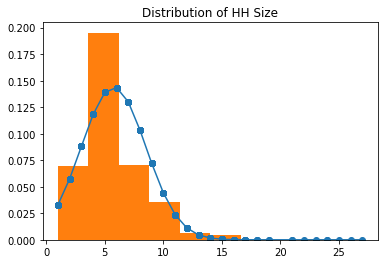

In [9]:

h = sorted(result['hh_size_hhinfo'].dropna())  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')
pl.hist(h,normed=True)
pl.title("Distribution of HH Size")
pl.show()  

In [10]:
a = result.gps_location_end.str.split(' ').dropna()
b = pd.DataFrame((item for item in a), columns = ['lat','long','alt','acc'])
b['lat'] = pd.to_numeric(b['lat'], errors='coerce')
b['long'] = pd.to_numeric(b['long'], errors='coerce')
b['ref'] = result['refusal']
b['comp'] = result['incomplete']


In [12]:
lat = b['lat'].values
lon = b['long'].values

url_base = 'http://server.arcgisonline.com/ArcGIS/rest/services/'
service = 'World_Street_Map/MapServer/tile/{z}/{y}/{x}'
tileset = url_base + service


map_osm = folium.Map(location=[b['lat'].mean(), 
   b['long'].mean()],zoom_start=5, control_scale = True, tiles=tileset, attr='USGS style')

mc = folium.plugins.MarkerCluster()

for row in b.itertuples():
    mc.add_child(folium.Marker(location=[row.lat,  row.long]))

map_osm.add_child(mc)

map_osm.get_root().add_child(folium.Element("<h1>Submitted Forms Mapped by GPS</h1>"))
map_osm